In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import seaborn as sns
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm,tqdm_notebook
import re
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [2]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from tqdm import tqdm,tqdm_notebook
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# DL Libs..

CWD is  /home/ec2-user/IS434


In [3]:
df_train = pd.read_csv('train.tsv', '\t')
df_train = df_train.sample(n = 500_000)
df_train_split ,df_test_split = train_test_split(df_train,test_size = 0.25)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 180987 to 1373480
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           500000 non-null  int64  
 1   name               500000 non-null  object 
 2   item_condition_id  500000 non-null  int64  
 3   category_name      497852 non-null  object 
 4   brand_name         286818 non-null  object 
 5   price              500000 non-null  float64
 6   shipping           500000 non-null  int64  
 7   item_description   499997 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 34.3+ MB


In [5]:
def fill_missing_data(data):
    data.brand_name.fillna(value = "Missing", inplace = True)
    data.category_name.fillna(value = "Missing", inplace = True)

fill_missing_data(df_train_split)
fill_missing_data(df_test_split)

In [6]:
df_train_split[df_train_split["price"] < 3].count()

train_id             233
name                 233
item_condition_id    233
category_name        233
brand_name           233
price                233
shipping             233
item_description     233
dtype: int64

In [7]:
df_train_split[df_train_split["price"] > 2000].count()

train_id             1
name                 1
item_condition_id    1
category_name        1
brand_name           1
price                1
shipping             1
item_description     1
dtype: int64

In [8]:
df_train_split = df_train_split[(df_train_split.price >= 3)]
df_test_split = df_test_split[(df_test_split.price >= 3)]

In [9]:
df_train_split['log_price'] = np.log1p(df_train_split['price'])
df_test_split['log_price'] = np.log1p(df_test_split['price'])

In [10]:
# function to decontract phrases
#https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def text_process(text):
    stop_words = stopwords.words('english')
    processed = []
    desc_length_tokenized = []
    for sentence in tqdm_notebook(text):
        sentence_decontracted = decontracted(sentence)
        sentence_decontracted = sentence_decontracted.replace('\\"', ' ')
        sentence_decontracted = sentence_decontracted.replace('\\`', ' ')
        sentence_decontracted = re.sub(r"[^0-9a-zA-Z]+", ' ', sentence_decontracted)
        text_tokens = word_tokenize(sentence_decontracted)
        desc_length_tokenized.append(len(text_tokens))
        joined_words = " ".join(word for word in text_tokens if word not in stop_words)
        processed.append(joined_words)
    return processed, desc_length_tokenized

In [11]:
df_train_split['item_description'] = df_train_split['item_description'].replace([np.nan],"No Description")
df_test_split['item_description'] = df_test_split['item_description'].replace([np.nan],"No Description")

In [12]:
df_train_split['item_desc_processed'], df_train_split['item_desc_length_tokenized'] = text_process(df_train_split['item_description'])
df_test_split['item_desc_processed'], df_test_split['item_desc_length_tokenized'] = text_process(df_test_split['item_description'])

In [13]:
def generate_sentiment_scores(sentences):
    analyzer = SentimentIntensityAnalyzer()
    results = []
    for sentence in tqdm_notebook(sentences): 
        sentence_sentiment_score = analyzer.polarity_scores(sentence)
        results.append(sentence_sentiment_score)
    return results

In [14]:
train_senti_desc = generate_sentiment_scores(df_train_split['item_description'])
test_senti_desc = generate_sentiment_scores(df_test_split['item_description'])

In [15]:
def get_sentiments(dataframe, array):
    negative, neutral, compound, positive = [], [], [], []
    for sentiment_dict in array:
        for sentiment, score in sentiment_dict.items():
            if(sentiment=='neg'):
                negative.append(score)
            elif(sentiment=='neu'):
                neutral.append(score)
            elif(sentiment=='compound'):
                compound.append(score)
            elif(sentiment=='pos'):
                positive.append(score)
    dataframe['negative'] = negative
    dataframe['positive'] = positive
    dataframe['neutral'] = neutral
    dataframe['compound'] = compound

In [16]:
get_sentiments(df_train_split,train_senti_desc)
get_sentiments(df_test_split,test_senti_desc)

In [17]:
def get_description_features(dataframe, sentence_df):
    percentage_of_exclamation_marks, percentage_of_star, percentage_of_ampersand, percentage_of_hashtag = [], [], [], []
    for description in sentence_df:
        hashtag_regex = re.compile(r'(#[a-z]{2,})')
        percentage_of_exclamation_marks.append(description.count('!')/len(description) * 100)
        percentage_of_star.append(description.count("*")/len(description)*100)
        percentage_of_ampersand.append(description.count("%")/len(description)*100)
        percentage_of_hashtag.append(len(hashtag_regex.findall(description))/len(description)*100)
    dataframe['percentage_of_exclamation_marks'] = percentage_of_exclamation_marks
    dataframe['percentage_of_star'] = percentage_of_star
    dataframe['percentage_of_ampersand'] = percentage_of_ampersand
    dataframe['percentage_of_hashtag'] = percentage_of_hashtag

In [18]:
get_description_features(df_train_split,df_train_split['item_description'])
get_description_features(df_test_split,df_test_split['item_description'])

In [19]:
tfidf_vectorizer=TfidfVectorizer(ngram_range=(1,3), min_df = 10, max_features=5000, use_idf=True) 
tfidf_vectorizer_vectors_train = tfidf_vectorizer.fit_transform(df_train_split['item_desc_processed'])
tfidf_vectorizer_vectors_test =tfidf_vectorizer.transform(df_test_split['item_desc_processed'])


X_train = tfidf_vectorizer_vectors_train
X_test = tfidf_vectorizer_vectors_test

y_train = df_train_split['log_price']
y_test = df_test_split['log_price']

In [20]:
print(tfidf_vectorizer_vectors_train)

  (0, 1387)	0.28856079083905173
  (0, 3932)	0.2900361642569315
  (0, 998)	0.22115963091232585
  (0, 1386)	0.1785088514784899
  (0, 4013)	0.1722104426674653
  (0, 2105)	0.2998172474170925
  (0, 1806)	0.30857461573437495
  (0, 4783)	0.1583007056347804
  (0, 3931)	0.25879818468160565
  (0, 2840)	0.1117419269691218
  (0, 972)	0.1049768773514481
  (0, 1385)	0.1676977923869877
  (0, 4069)	0.13666180427097693
  (0, 3956)	0.08733933798725786
  (0, 4809)	0.15053849354178708
  (0, 1803)	0.181942267551776
  (0, 2099)	0.320112502973337
  (0, 3898)	0.17713781813463012
  (0, 567)	0.1903156640787894
  (0, 1137)	0.1525943585310308
  (0, 4722)	0.2959059352379891
  (0, 4971)	0.17441431516426412
  (1, 1793)	0.30482209843539315
  (1, 4901)	0.32395107004604734
  (1, 3957)	0.24914288719820563
  :	:
  (374765, 4421)	0.2562321151104204
  (374765, 1772)	0.3162170576409916
  (374765, 3820)	0.24817868119638922
  (374765, 2264)	0.2309723295429906
  (374765, 1766)	0.1661499715385973
  (374765, 1112)	0.343084434781

In [21]:
print(y_train)

1009958    2.397895
872123     3.737670
612286     3.332205
862825     5.398163
603962     3.295837
             ...   
944441     2.772589
490706     4.025352
1271202    2.302585
349049     3.610918
1249346    5.393628
Name: log_price, Length: 374767, dtype: float64


In [22]:
from lightgbm import LGBMRegressor
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

lgbm_params ={
    'learning_rate': 0.1,
    'n_estimators': 400,
    'num_leaves': 140,
    'max_depth' : 60,
    'boosting_type' : 'gbdt',
    'subsample': 0.9, 
    'colsample_bytree': 0.8, 
    'min_child_samples': 20, 
    'objective': 'regression'
             }

lgbm_model = LGBMRegressor(**lgbm_params)
model = lgbm_model.fit(X_train, y_train, early_stopping_rounds=None,verbose=True)

pred_train = lgbm_model.predict(X_train)
pred_test  = lgbm_model.predict(X_test)

In [23]:
# importing SHAP
import shap

# sampling data from the training and test set to reduce time-taken
X_train_sample = shap.sample(X_train, 200)
X_test_sample = shap.sample(X_test, 40)

# creating the KernelExplainer using the logistic regression model and training sample
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer 
shap_vals = SHAP_explainer.shap_values(X_test_sample)

# converting the test samples to a dataframe 
# this is necessary for non-tabular data in order for the visualisations 
# to include feature value
colour_test = pd.DataFrame(X_test_sample.todense())

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


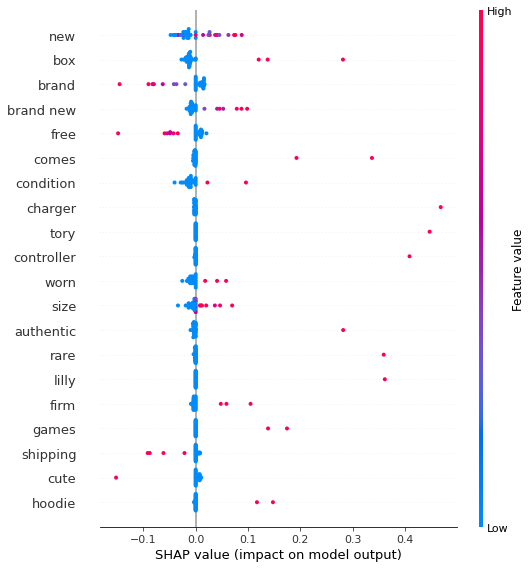

In [24]:
shap.summary_plot(shap_vals, colour_test, feature_names=tfidf_vectorizer.get_feature_names())